In [90]:
% matplotlib inline 

from neurosynth.base.dataset import Dataset
from neurosynth.analysis import decode
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['svg.fonttype'] = 'none'

In [12]:
def getOrder(d, thr):
    dh = []
    for i in range(0,len(d)):
        di = d[i]
        dh.append(np.average(np.array(xrange(0,len(d[i]))) + 1, weights=di))
    heatmapOrder = np.argsort(dh)
    return heatmapOrder

In [4]:
# Import neurosynth database:
pickled_dataset = '../topography/metaanalysis/neurosynth/dataset.pkl' #'gradient_data/neurosynth/dataset.pkl'
dataset = Dataset.load(pickled_dataset)

In [80]:
# include code to convert surface embedding to volume...

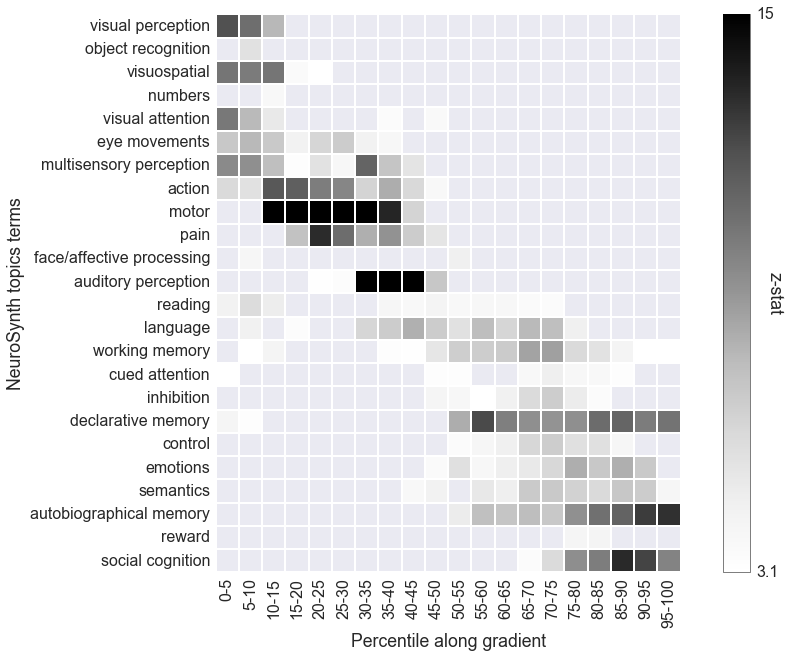

In [121]:
# Analysis with 24 terms:
features = pd.read_csv('gradient_data/neurosynth/v3-topics-50.txt', sep='\t', index_col=0)
topics_to_keep = [1, 4, 6, 14, 18, 17, 
                  23, 25, 20, 21, 27,
                  29, 30, 31, 33, 35, 
                  36,  38, 37, 41, 44, 
                  45, 48, 49]
labels = ['face/affective processing', 'semantics', 'cued attention', 'working memory',  'autobiographical memory', 'reading',
          'inhibition', 'motor', 'visual perception', 'numbers', 'reward',
          'visual attention', 'multisensory perception', 'visuospatial','eye movements', 'action',
          'auditory perception',  'pain',  'language', 'declarative memory', 'object recognition', 
          'emotions', 'control', 'social cognition']            
features = features.iloc[:, topics_to_keep]
features.columns = labels
dataset.add_features(features, append=False)

# removed = [0,5,9,12,19,40] # from 30 terms that were above threshold
# not_used_labels = [ 'resting-state', 'dimentia', 'development', 'misc', 'task timing', 'lateralization']

decoder = decode.Decoder(dataset, method='roi')

# Set threshold:
thr = 3.1
vmin = 0
vmax = 15

tot = 5
data = decoder.decode([str('gradient_data/masks/volume_%02d_%02d.nii.gz' % (i * tot, (i * tot) + tot)) 
                       for i in xrange(0,100/tot)])
df = []
df = data.copy()
newnames = []
[newnames.append(('%s-%s' % (str(i * tot), str((i*tot) + tot)))) for i in xrange(0,len(df.columns))]
df.columns = newnames
df[df<thr] = 0 
heatmapOrder = getOrder(np.array(df), thr)

sns.set(context="paper", font="sans-serif", font_scale=2)
f, (ax1) = plt.subplots(nrows=1,ncols=1,figsize=(15, 10), sharey=True)
plotData = df.reindex(df.index[heatmapOrder])
cax = sns.heatmap(plotData, linewidths=1, square=True, cmap='Greys', robust=False, 
            ax=ax1, vmin=thr, vmax=vmax, mask=plotData == 0)
sns.axlabel('Percentile along gradient', 'NeuroSynth topics terms')
cbar = cax.collections[0].colorbar
cbar.set_label('z-stat', rotation=270)
cbar.set_ticks(ticks=[thr,vmax])
cbar.set_ticklabels(ticklabels=[thr,vmax])
cbar.outline.set_edgecolor('black')
cbar.outline.set_linewidth(0.5)

plt.draw()
f.savefig('gradient_data/figures/fig.supp.neurosynth.24.svg', format='svg')